In [ ]:
import pandas as pd
import numpy as np
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.preprocessing import LabelEncoder
import re
print("Tensorflow Version",tf.__version__)

In [2]:
usecols_train=['text','target']
usecols_test=['id','text']

In [3]:
df_train=pd.read_csv("train.csv",usecols=usecols_train,encoding='cp437')
df_test=pd.read_csv("test.csv",usecols=usecols_test)

In [4]:
df_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [5]:
lab_to_sentiment = {0:"Non Disaster", 1:"Disaster"}
def label_decoder(label):
    return lab_to_sentiment[label]
df_train.target = df_train.target.apply(lambda x: label_decoder(x))
df_train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,Disaster
1,Forest fire near La Ronge Sask. Canada,Disaster
2,All residents asked to 'shelter in place' are ...,Disaster
3,"13,000 people receive #wildfires evacuation or...",Disaster
4,Just got sent this photo from Ruby #Alaska as ...,Disaster


In [6]:
df_test.shape

(3263, 2)

Text(0.5, 1.0, 'Sentiment Data Distribution')

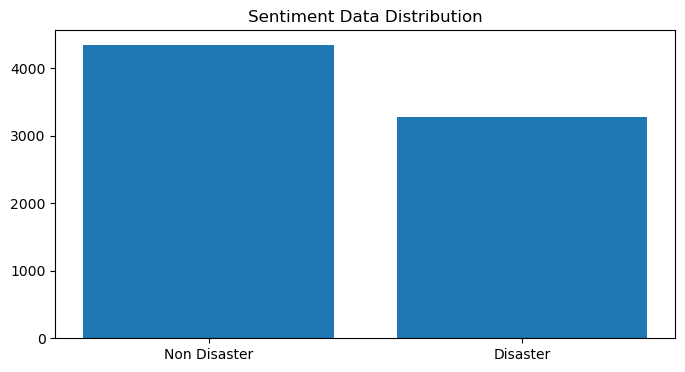

In [7]:
val_count = df_train.target.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [8]:
import random
random_idx_list = [random.randint(1,len(df_train.text)) for i in range(10)] # creates random indexes to choose from dataframe
df_train.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,text,target
1953,@mccauleysdesign @abysmaljoiner @DyamiPlotke i...,Non Disaster
2712,Ignition Knock (Detonation) Sensor-Senso Stand...,Non Disaster
3597,11-Year-Old Boy Charged With Manslaughter of T...,Disaster
3443,Well as I was chaning an iPad screen it fuckin...,Non Disaster
4887,Colorado movie massacre trial jurors reach ver...,Disaster
6436,13 security personnel killed in Iraq suicide b...,Disaster
752,i'd still be team usagi even if she blew up th...,Non Disaster
3172,Our builder is having a dental emergency. Whic...,Disaster
6499,Hank Williams Jr. - 'Country Boys Can Survive'...,Non Disaster
5218,I need an arcade shooter fix but CTE is empty ...,Non Disaster


In [9]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [10]:
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [11]:
df_train.text = df_train.text.apply(lambda x: preprocess(x))

In [12]:
df_train.head()

,text,target
0,deeds reason earthquake may allah forgive us,Disaster
1,forest fire near la ronge sask canada,Disaster
2,residents asked shelter place notified officer...,Disaster
3,13 000 people receive wildfires evacuation ord...,Disaster
4,got sent photo ruby alaska smoke wildfires pou...,Disaster


In [13]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [14]:
train_data, test_data = train_test_split(df_train, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 6090
Test Data size 1523


In [15]:
train_data.head()

,text,target
2346,delmont onion house purchased plans demolition,Disaster
1857,minute alone crush overrated experience smh,Non Disaster
3412,brain id explode lmao,Non Disaster
3581,fatal attraction common n common pain,Non Disaster
5538,worst radiation exposure fukushima meltdown ha...,Disaster


In [16]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 13710


In [17]:
#from keras_preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)
x_val=pad_sequences(tokenizer.texts_to_sequences(df_test.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)
print("Val X Shape:",x_val.shape)

Training X Shape: (6090, 30)
Testing X Shape: (1523, 30)
Val X Shape: (3263, 30)


In [18]:
labels = train_data.target.unique().tolist()

In [19]:
encoder = LabelEncoder()
encoder.fit(train_data.target.to_list())

y_train = encoder.transform(train_data.target.to_list())
y_test = encoder.transform(test_data.target.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (6090, 1)
y_test shape: (1523, 1)


# gloVe

In [20]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-08-23 07:18:37--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-08-23 07:18:37--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-08-23 07:18:37--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [21]:
GLOVE_EMB = 'glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10

In [22]:
MODEL_PATH = r'D:\Downloads\best_model.hdf5'

In [23]:
x_train

array([[    0,     0,     0, ...,  3724,   565,   507],
       [    0,     0,     0, ...,  5599,  1682,  1683],
       [    0,     0,     0, ...,  2281,   218,   732],
       ...,
       [    0,     0,     0, ..., 13705, 13706,  3617],
       [    0,     0,     0, ...,  2537,    63,    17],
       [    0,     0,     0, ...,     7, 13709,  2207]], dtype=int32)

In [24]:
embeddings_index = {}

f = open(GLOVE_EMB,encoding='cp437')
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [25]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [26]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

In [27]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [28]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [29]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [30]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Training on CPU...


In [31]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
6/6 [==============================] - 15s 998ms/step - loss: 0.6477 - accuracy: 0.6315 - val_loss: 0.5295 - val_accuracy: 0.7735 - lr: 0.0010
Epoch 2/10
6/6 [==============================] - 4s 748ms/step - loss: 0.5013 - accuracy: 0.7772 - val_loss: 0.5015 - val_accuracy: 0.7912 - lr: 0.0010
Epoch 3/10
6/6 [==============================] - 5s 767ms/step - loss: 0.4651 - accuracy: 0.7951 - val_loss: 0.4656 - val_accuracy: 0.7984 - lr: 0.0010
Epoch 4/10
6/6 [==============================] - 4s 733ms/step - loss: 0.4338 - accuracy: 0.8056 - val_loss: 0.4599 - val_accuracy: 0.8037 - lr: 0.0010
Epoch 5/10
6/6 [==============================] - 4s 738ms/step - loss: 0.4234 - accuracy: 0.8172 - val_loss: 0.4504 - val_accuracy: 0.8030 - lr: 0.0010
Epoch 6/10
6/6 [==============================] - 5s 813ms/step - loss: 0.3949 - accuracy: 0.8309 - val_loss: 0.4451 - val_accuracy: 0.8076 - lr: 0.0010
Epoch 7/10
6/6 [==============================] - 4s 714ms/step - loss: 0.3853 - 

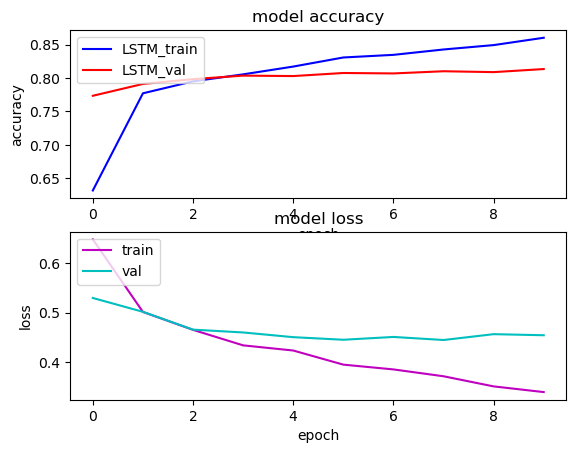

In [32]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [33]:
def decode_sentiment(score):
    return "Non Disaster" if score>0.5 else "Disaster"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

1/1 [==============================] - 1s 820ms/step


In [34]:
score_val=model.predict(x_val, verbose=1, batch_size=10000)

1/1 [==============================] - 0s 462ms/step


In [35]:
y_val_1d = [decode_sentiment(score) for score in score_val]

In [36]:
len(y_val_1d)

3263

In [37]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

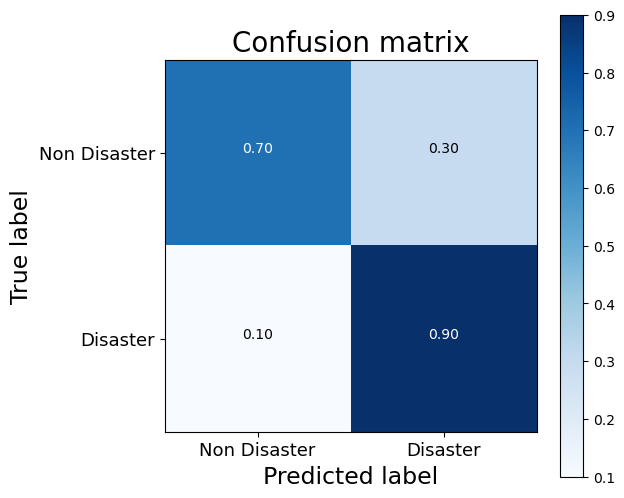

In [38]:
cnf_matrix = confusion_matrix(test_data.target.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.target.unique(), title="Confusion matrix")
plt.show()

In [39]:
print(classification_report(list(test_data.target), y_pred_1d))

              precision    recall  f1-score   support

    Disaster       0.84      0.70      0.77       662
Non Disaster       0.80      0.90      0.85       861

    accuracy                           0.81      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.82      0.81      0.81      1523

